In [1]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (15, 5)

train = pd.read_pickle('Data/student_train_logs_agg')
test = pd.read_pickle('Data/student_test_logs_agg')

target = 'isSTEM'
IDcol = 'ITEST_id'
columns_not_keep = [
    target,
    IDcol,
    'SY ASSISTments Usage',
    'skill',
    'problemId',
    'assignmentId',
    'assistmentId',
    'problemType',
    'SY ASSISTments Usage_std',
    'skill_std',
    'problemId_std',
    'assignmentId_std',
    'assistmentId_std',
    'problemType_std'
]



/home/dario/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/dario/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [96]:
test_isSTEM = []

for i in range(test.shape[0]):
    idx = test.iloc[i].name
    if idx in train.index:
        test_isSTEM.append(idx)

In [2]:
train_balanced = pd.concat([train[train['isSTEM'] == 1], train[train['isSTEM'] == 0][:150]])
train = train_balanced.sample(frac=1)
train.head()

,SY ASSISTments Usage,AveKnow,AveCarelessness,AveCorrect,NumActions,AveResBored,AveResEngcon,AveResConf,AveResFrust,AveResOfftask,...,confidence(GAMING)_std,RES_BORED_std,RES_CONCENTRATING_std,RES_CONFUSED_std,RES_FRUSTRATED_std,RES_OFFTASK_std,RES_GAMING_std,isSTEM,MCAS,SchoolId
ITEST_id,,,,,,,,,,,,,,,,,,,,,
3256,1.0,0.220022,0.159168,0.383459,133.0,0.267365,0.623334,0.111789,0.235714,0.260731,...,0.188775,0.130420,0.137942,0.262158,0.388451,0.265128,0.122742,0.0,-999.0,4.0
3061,0.0,0.189824,0.097979,0.368765,1684.0,0.196944,0.688215,0.062010,0.119483,0.105072,...,0.388386,0.091313,0.171787,0.205311,0.281959,0.132571,0.425193,0.0,34.0,2.0
9,1.0,0.185138,0.099734,0.438492,504.0,0.277149,0.644744,0.098078,0.162771,0.213378,...,0.122681,0.125372,0.160885,0.228893,0.333023,0.226656,0.023455,1.0,32.0,2.0
2106,0.0,0.110055,0.063054,0.363636,121.0,0.287515,0.605511,0.207109,0.161529,0.312332,...,0.217950,0.130539,0.178566,0.363523,0.318367,0.300293,0.154723,0.0,28.0,4.0
4546,0.0,0.196124,0.128192,0.326565,591.0,0.228290,0.629303,0.084522,0.095464,0.155885,...,0.289784,0.108938,0.193812,0.219004,0.259780,0.181715,0.262026,1.0,38.0,4.0


In [3]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=7, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target], eval_metric='auc') 
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

[0]	train-auc:0.853741+0.0250746	test-auc:0.636006+0.0579347
[1]	train-auc:0.93044+0.0183984	test-auc:0.669475+0.0482777
[2]	train-auc:0.955671+0.0110737	test-auc:0.66532+0.0442155
[3]	train-auc:0.967646+0.00488858	test-auc:0.68718+0.0273329
[4]	train-auc:0.975721+0.00512247	test-auc:0.693603+0.038251
[5]	train-auc:0.981509+0.00489014	test-auc:0.704969+0.0463751
[6]	train-auc:0.985109+0.00442145	test-auc:0.704311+0.0477676
[7]	train-auc:0.986681+0.00319097	test-auc:0.696588+0.0411544
[8]	train-auc:0.986646+0.00296746	test-auc:0.700271+0.0478655
[9]	train-auc:0.988288+0.00323909	test-auc:0.698045+0.0382416
[10]	train-auc:0.989657+0.00392765	test-auc:0.689177+0.0453605
[11]	train-auc:0.991028+0.00404878	test-auc:0.685746+0.0464049
[12]	train-auc:0.991501+0.00416444	test-auc:0.687748+0.0444952
[13]	train-auc:0.991858+0.0039356	test-auc:0.679154+0.0407646
[14]	train-auc:0.992443+0.0038231	test-auc:0.675724+0.0407043
[15]	train-auc:0.993169+0.00364607	test-auc:0.677088+0.0469467
[16]	train-

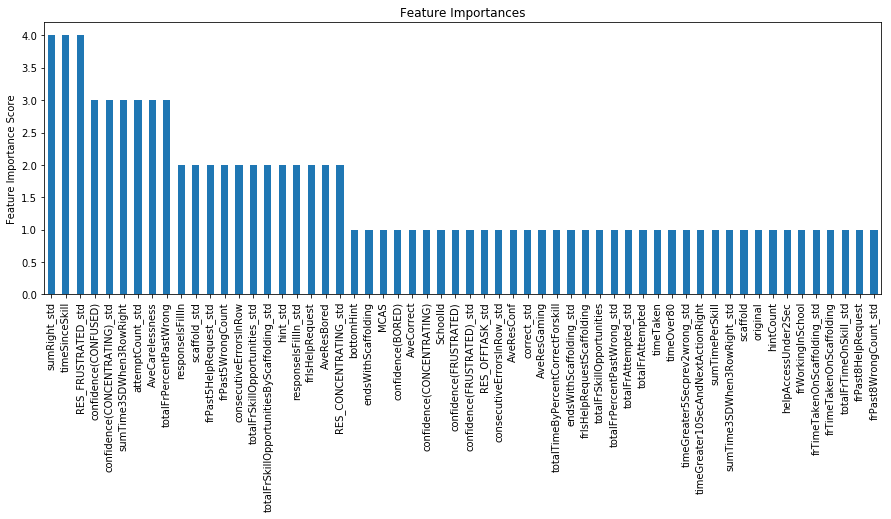

In [7]:
predictors = [x for x in train.columns if x not in columns_not_keep]

xgb1 = XGBClassifier(
 learning_rate =0.005,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

In [8]:
param_test1 = {
 'max_depth': list(range(8,15,2)),
 'min_child_weight': list(range(1,6,2))
}

xgb2 = XGBClassifier(
    learning_rate =0.05,
    n_estimators=54,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

gsearch1 = GridSearchCV(estimator = xgb2, param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=7)
gsearch1.fit(train[predictors], train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.66838, std: 0.08944, params: {'max_depth': 8, 'min_child_weight': 1},
  mean: 0.68457, std: 0.09877, params: {'max_depth': 8, 'min_child_weight': 3},
  mean: 0.68005, std: 0.07516, params: {'max_depth': 8, 'min_child_weight': 5},
  mean: 0.68177, std: 0.10915, params: {'max_depth': 10, 'min_child_weight': 1},
  mean: 0.68457, std: 0.09877, params: {'max_depth': 10, 'min_child_weight': 3},
  mean: 0.68005, std: 0.07516, params: {'max_depth': 10, 'min_child_weight': 5},
  mean: 0.67952, std: 0.10501, params: {'max_depth': 12, 'min_child_weight': 1},
  mean: 0.68457, std: 0.09877, params: {'max_depth': 12, 'min_child_weight': 3},
  mean: 0.68005, std: 0.07516, params: {'max_depth': 12, 'min_child_weight': 5},
  mean: 0.67952, std: 0.10501, params: {'max_depth': 14, 'min_child_weight': 1},
  mean: 0.68457, std: 0.09877, params: {'max_depth': 14, 'min_child_weight': 3},
  mean: 0.68005, std: 0.07516, params: {'max_depth': 14, 'min_child_weight': 5}],
 {'max_depth': 8, 'min_child_w

In [10]:
param_test2 = {
 'max_depth': [7,8,9],
 'min_child_weight':[2, 3, 4]
}

xgb3 = XGBClassifier(
    learning_rate =0.05,
    n_estimators=54,
    max_depth=8,
    min_child_weight=8,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

gsearch2 = GridSearchCV(estimator = xgb3, param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=7)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_


([mean: 0.66989, std: 0.08129, params: {'max_depth': 7, 'min_child_weight': 2},
  mean: 0.68140, std: 0.10506, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.68052, std: 0.09782, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: 0.66445, std: 0.09061, params: {'max_depth': 8, 'min_child_weight': 2},
  mean: 0.68457, std: 0.09877, params: {'max_depth': 8, 'min_child_weight': 3},
  mean: 0.68052, std: 0.09782, params: {'max_depth': 8, 'min_child_weight': 4},
  mean: 0.66488, std: 0.09066, params: {'max_depth': 9, 'min_child_weight': 2},
  mean: 0.68457, std: 0.09877, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.68052, std: 0.09782, params: {'max_depth': 9, 'min_child_weight': 4}],
 {'max_depth': 8, 'min_child_weight': 3},
 0.6845738295318127)

* max_depth: 10
* min_child_weight: 1
* learning_rate: 0.05
* n_estimators: 105

In [11]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0, 5)]
}

xgb4 = XGBClassifier(
    learning_rate =0.05,
    n_estimators=54,
    max_depth=8,
    min_child_weight=3,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)

gsearch3 = GridSearchCV(estimator = xgb4, param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=7)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.68457, std: 0.09877, params: {'gamma': 0.0},
  mean: 0.67921, std: 0.10688, params: {'gamma': 0.1},
  mean: 0.69003, std: 0.10011, params: {'gamma': 0.2},
  mean: 0.68400, std: 0.09766, params: {'gamma': 0.3},
  mean: 0.68484, std: 0.10716, params: {'gamma': 0.4}],
 {'gamma': 0.2},
 0.690032831314344)

[0]	train-auc:0.825703+0.0133051	test-auc:0.613504+0.0616035
[1]	train-auc:0.879937+0.015878	test-auc:0.6534+0.0454633
[2]	train-auc:0.907728+0.0153927	test-auc:0.651606+0.0476544
[3]	train-auc:0.924656+0.00795382	test-auc:0.660779+0.0466918
[4]	train-auc:0.934131+0.00785356	test-auc:0.684165+0.0408055
[5]	train-auc:0.946648+0.00429878	test-auc:0.683282+0.0470243
[6]	train-auc:0.953114+0.00513457	test-auc:0.681562+0.0418942
[7]	train-auc:0.959101+0.00679389	test-auc:0.680855+0.0366126
[8]	train-auc:0.958929+0.00603333	test-auc:0.683934+0.0551738
[9]	train-auc:0.962464+0.00511084	test-auc:0.684439+0.0495448
[10]	train-auc:0.965667+0.00451427	test-auc:0.691553+0.0546397
[11]	train-auc:0.968905+0.00670742	test-auc:0.692504+0.0493168
[12]	train-auc:0.971113+0.0064911	test-auc:0.692397+0.0529461
[13]	train-auc:0.974366+0.00606862	test-auc:0.695332+0.0542382
[14]	train-auc:0.974482+0.00560851	test-auc:0.696673+0.0487119
[15]	train-auc:0.976233+0.00601438	test-auc:0.697433+0.0504728
[16]	trai

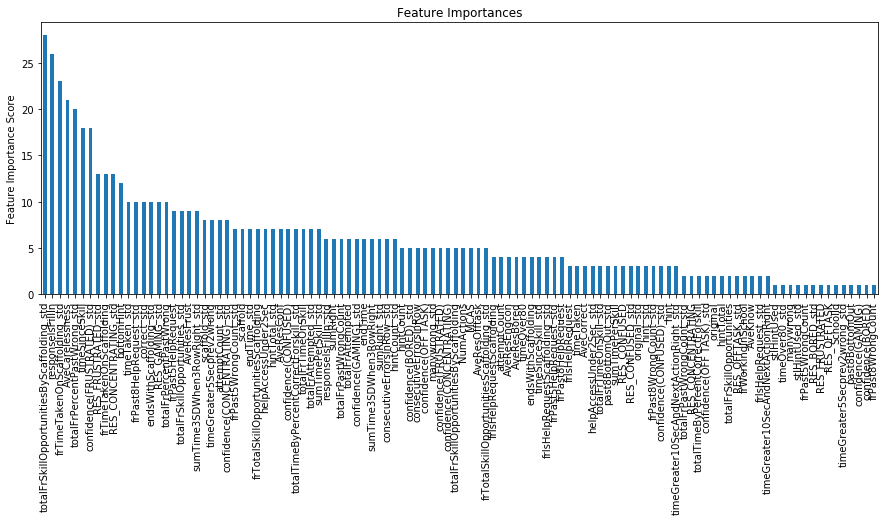

In [12]:
xgb5 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=8,
 min_child_weight=3,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb5, train, predictors, cv_folds=7)

In [14]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xgb6 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=54,
 max_depth=8,
 min_child_weight=3,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

gsearch4 = GridSearchCV(estimator = xgb6, param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=7)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.67489, std: 0.09900, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.67637, std: 0.07512, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.68497, std: 0.08947, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.68170, std: 0.10513, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.67536, std: 0.08987, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.67178, std: 0.07828, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.69383, std: 0.08868, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.68764, std: 0.07974, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.65949, std: 0.07925, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.67305, std: 0.09498, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.69003, std: 0.10011, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.68001, std: 0.10316, params: {'colsample_bytree': 0.8, 'subsample'

[0]	train-auc:0.797857+0.0263507	test-auc:0.611308+0.0681854
[1]	train-auc:0.85563+0.0215778	test-auc:0.614145+0.0701243
[2]	train-auc:0.88184+0.0145154	test-auc:0.637+0.0689183
[3]	train-auc:0.901705+0.0157085	test-auc:0.659384+0.0490969
[4]	train-auc:0.915804+0.0150765	test-auc:0.661954+0.0501398
[5]	train-auc:0.926967+0.0150849	test-auc:0.666009+0.0526529
[6]	train-auc:0.935039+0.0129389	test-auc:0.690163+0.0589384
[7]	train-auc:0.94005+0.0137121	test-auc:0.690173+0.0556326
[8]	train-auc:0.944826+0.0119756	test-auc:0.690536+0.0618313
[9]	train-auc:0.949196+0.0121638	test-auc:0.70736+0.0654298
[10]	train-auc:0.952466+0.0131339	test-auc:0.709225+0.0646747
[11]	train-auc:0.955398+0.0134454	test-auc:0.714908+0.06413
[12]	train-auc:0.960859+0.0117982	test-auc:0.715209+0.0544875
[13]	train-auc:0.96282+0.0114482	test-auc:0.715943+0.055878
[14]	train-auc:0.965206+0.0109864	test-auc:0.706747+0.0518885
[15]	train-auc:0.966625+0.0103488	test-auc:0.704589+0.0517134
[16]	train-auc:0.969183+0.010

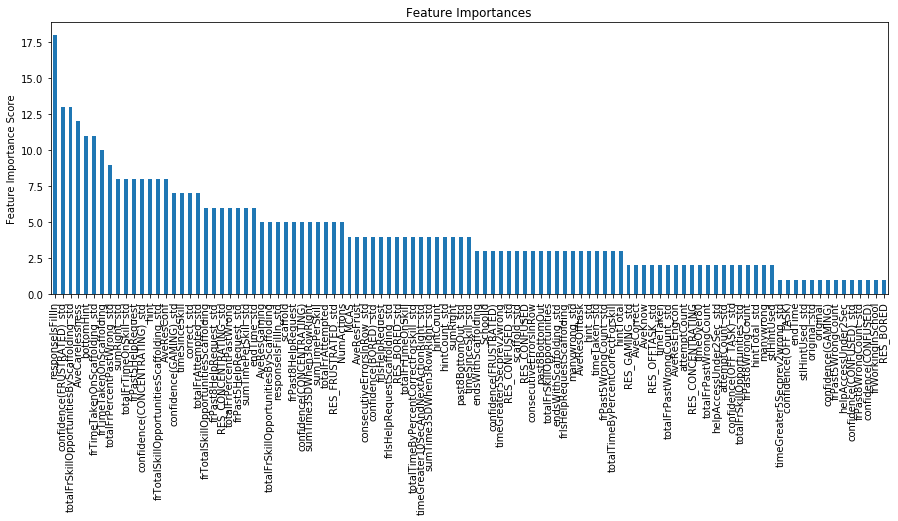

In [15]:
xgbFinal = XGBClassifier(
 learning_rate =0.05,
 n_estimators=54,
 max_depth=8,
 min_child_weight=3,
 gamma=0.2,
 subsample=0.7,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgbFinal, train, predictors, cv_folds=7)

## Predictions

In [16]:
predictors = [x for x in train.columns if x not in columns_not_keep]
for probas in xgbFinal.predict_proba(test[predictors]):
    print(probas[1], end=',')

0.711724,0.364616,0.724765,0.441669,0.805643,0.747805,0.48394,0.6012,0.773621,0.412205,0.319141,0.55823,0.445138,0.670736,0.744319,0.490884,0.566039,0.216209,0.519764,0.156837,0.71748,0.552862,0.661951,0.287858,0.170977,0.460616,0.514253,0.338276,0.378775,0.578087,0.5788,0.282585,0.263138,0.587215,0.215283,0.410085,0.303329,0.419864,0.584261,0.745599,0.431392,0.569744,0.166116,0.681182,0.135165,0.339678,0.218821,0.244909,0.687846,0.199933,0.493339,0.100458,0.601401,0.352815,0.569452,0.653656,0.13569,0.54808,0.570779,0.650496,0.626849,0.487016,0.712374,0.49852,0.499572,0.706375,0.315531,0.830527,0.798762,0.506589,0.800586,0.312415,0.767181,0.363517,0.807542,0.448681,0.293568,0.667912,0.774712,0.770793,0.636819,0.587244,0.404301,0.845148,0.468257,0.388513,0.642917,0.392158,0.26899,0.671458,0.440359,0.378948,0.844912,0.533575,0.7114,0.615658,0.267952,0.821,0.335208,0.65994,0.780012,0.629905,0.550853,0.79922,0.309171,0.776101,0.781421,0.13925,0.755686,0.773044,0.667539,0.488289,0.720353,0.